# UFO Algorithms Lab

<u>Use Case</u>
<p>Mr. K wants to build a model that can predict the legitimacy of a UFO sighting based on information supplied by the submitter. 
We can use the ground truth dataset used in the previous lab. This data has been collected by Mr. K's team who painstakingly determined whether a sighting could be explained (as a hoax or other natural explanation), unexplained, or probable. 
</p>

<u>Goal</u>
<p>build a model to determine whether newly reported UFO sightings are legitimate or not (explained, unexplained, or probable), <br>the model need to be at least 90% accurate</p>

<u>Notebook - Table Of Contents</u>

1. [Data Collection](#dc)
1. [Assumptions](#a)
1. [Model Selection](#m)
1. [Handling Missing Values](#hmv)
1. [EDA](#eda)
1. [Feature Selection](#fs)
1. [Data Preparation](#dp)
1. [Train Models](#tm)
    1. [Linear Learner Model](#llm)
    1. [XGBoost Model](#xgbm)
1. [Results](#res)

<u>Note</u>
<p>in every code cell that I'm using external libraries I'm importing it every time, although I can import all of them once on the start of the notebook, I wanted to show what libraries I'm using on every step</p>

## Data Collection<a id='dc'></a>
### Downloading a File from an S3 Bucket to Notebook instance

In [2]:
'''
import boto3
import botocore

bucket_name = '<PUT_HERE_THE_BUCKET_NAME>'
file_name = 'ufo_fullset.csv'
file_path = 'AlgorithmsLab - 2019/'+file_name

s3 = boto3.resource('s3')

try:
    s3.Bucket(bucket_name).download_file(file_path, file_name)
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise
'''

'\nimport boto3\nimport botocore\n\nbucket_name = \'<PUT_HERE_THE_BUCKET_NAME>\'\nfile_name = \'ufo_fullset.csv\'\nfile_path = \'AlgorithmsLab - 2019/\'+file_name\n\ns3 = boto3.resource(\'s3\')\n\ntry:\n    s3.Bucket(bucket_name).download_file(file_path, file_name)\nexcept botocore.exceptions.ClientError as e:\n    if e.response[\'Error\'][\'Code\'] == "404":\n        print("The object does not exist.")\n    else:\n        raise\n'

### Load Data from CSV File to DataFrame using Pandas<a id='LoadData'></a>

In [3]:
import pandas as pd 

file_name = 'ufo_fullset.csv'
data = pd.read_csv(file_name)
data.head()

,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
0,1977-04-04T04:02:23.340Z,1977-03-31,23:46,circle,4,1,rain,Ila,Bashirian,47.329444,-122.578889,Y,N,N,explained
1,1982-11-22T02:06:32.019Z,1982-11-15,22:04,disk,4,1,partly cloudy,Eriberto,Runolfsson,52.664913,-1.034894,Y,Y,N,explained
2,1992-12-07T19:06:52.482Z,1992-12-07,19:01,circle,49,1,clear,Miller,Watsica,38.951667,-92.333889,Y,N,N,explained
3,2011-02-24T21:06:34.898Z,2011-02-21,20:56,disk,13,1,partly cloudy,Clifton,Bechtelar,41.496944,-71.367778,Y,N,N,explained
4,1991-03-09T16:18:45.501Z,1991-03-09,11:42,circle,17,1,mostly cloudy,Jayda,Ebert,47.606389,-122.330833,Y,N,N,explained


<u>Feature Explanation</u>
<ul>
<li>reportedTimestamp: The date when the UFO sighting was reported</li><li>eventDate: The date when the UFO sighting happened</li><li>eventTime: The time when the UFO sighting happened (24 hour format)</li><li>latitude: The location where the UFO sighting happened</li><li>longitude: The location where the UFO sighting happened</li><li>shape: The shape of the UFO</li><li>duration: How many seconds the sighting happened</li><li>witnesses: The amount of witnesses that saw the UFO</li><li>weather: The weather when the sighting happened</li><li>firstName: The first name of the person who saw a UFO</li><li>lastName: The last name of the person who saw a UFO</li><li>sighting: If a UFO was sighted (is always Y = Yes)</li><li>physicalEvidence: Whether there was physical evidence left by UFO (Y = Yes, N = No)</li><li>contact: Whether there was contact by UFO beings (Y = Yes, N = No)</li><li>researchOutcome: Whether the experts had an explanation for sighting</li><ul>
<li>explained: There was some explanation to the sighting</li>
<li>unexplained: There was no explanation to the sighting</li>
<li>probable: There is enough evidence that the sighting were from extraterrestrials 
</ul></ul>

## Assumptions<a id='a'></a>
<p>
    it is needed to determine whether newly reported UFO sighting is belong to one of the next groups: explained, unexplained, or probable.<br>
    it's a supervised and classification problem - we will get a sighting without 'researchOutcome' field and we will need to predict it (this is the target/label).
</p>

## Model Selection<a id='m'></a>
<p>
    before run to do EDA, data cleansing/analyzing/preparing adventure I decided to select the model first and then I will know what data to use and how to prepare it.
</p>
<p>
    <a href="https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html">Use Amazon SageMaker Built-in Algorithms,</a> we have 3 algorithms that can do the job: "Linear Learner", "K-Nearest Neighbor", and "XGBoost".<br>
    the problem with "K-Nearest Neighbor" is that it a lazy algorithm, Does not use training data points to generalize but rather uses them to figure out who's nearby. so it doesn't "learn" but rather uses the training dataset to decide on similar samples. <u>that is why I will not use it.</u><br>
    <b>thus, I will use "Linear Learner" and "XGBoost" to solve this problem.</b>
</p>


## Handling Missing Values<a id='hmv'></a>

In [4]:
data.isnull().sum()

reportedTimestamp    0
eventDate            0
eventTime            0
shape                2
duration             0
witnesses            0
weather              0
firstName            0
lastName             0
latitude             0
longitude            0
sighting             0
physicalEvidence     0
contact              0
researchOutcome      0
dtype: int64

here are only 2 rows with missing data out of 18,000 records (around 0.01% of the data), dropping these rows will not cause any change in our final model.

In [5]:
data=data.dropna(axis = 0, how ='any')
data.isnull().values.any()

False

All missing values have been removed

## Exploratory data analysis (EDA)<a id='eda'></a>
### EDA for Target
understanding how the target variable <em>'researchOutcome'</em> is distributed. 

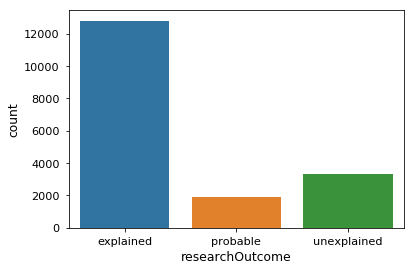

In [7]:
# Distribution for researchOutcome
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.4)

#change 'researchOutcome' feature to 'category' type in the DataFrame
data['researchOutcome']=data['researchOutcome'].astype('category') 

sns.countplot(x='researchOutcome',data=data)
plt.show()

### EDA for Categorical Features

In [8]:
some_cat_feature_list=['witnesses','shape','weather','sighting','physicalEvidence','contact','firstName','lastName']
#change Categorical Features to 'category' type in the DataFrame
for cat in some_cat_feature_list:     
    data[cat]=data[cat].astype('category')

# change 'eventDate' to datetime
data['eventDate']= pd.to_datetime(data['eventDate'],format='%Y-%m-%d')

# it was decided to drop 'reportedTimestamp' feature, we already have 'eventDate' and 'eventTime' as separate features
data.drop('reportedTimestamp', axis=1, inplace=True)

In [9]:
cat_feature_list=['witnesses','shape','weather','sighting','physicalEvidence','contact','eventTime','firstName','lastName','eventDate']
data[cat_feature_list].describe()

,witnesses,shape,weather,sighting,physicalEvidence,contact,eventTime,firstName,lastName,eventDate
count,17998.0,17998,17998,17998,17998,17998,17998,17998,17998,17998
unique,10.0,9,7,1,2,2,1440,2995,474,11354
top,10.0,circle,clear,Y,N,N,07:17,Hailee,Paucek,1973-03-02 00:00:00
freq,1852.0,6047,3206,17998,15312,16598,25,17,60,7
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1969-12-31 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-22 00:00:00


<ul>
    <li>it was decided to split 'eventDate' feature to 'year' and 'month' features</li>
    <li>it was decided to remove form 'eventTime' the minutes</li>
</ul>
    
<p>
in the current format, they are not adding any new information and to reduce the number of unique values for each feature
</p>

In [10]:
# hour columns cleansing for eventTime
data['eventTime']=data['eventTime'].str[:2]
data['eventTime']=data['eventTime'].astype('category')

In [11]:
# date columns cleansing eventDate
data['eventDate_year']=data['eventDate'].dt.year
data['eventDate_year']=data['eventDate_year'].astype('category')
data['eventDate_month']=data['eventDate'].dt.month
data['eventDate_month']=data['eventDate_month'].astype('category')

data.drop('eventDate', axis=1, inplace=True) # drop 'eventDate' column

'firstName' and 'lastName' features are not showing in the next charts because they have a huge number of unique values (see table above), they will be dropped in the 'Feature Selection' section

#### Histograms

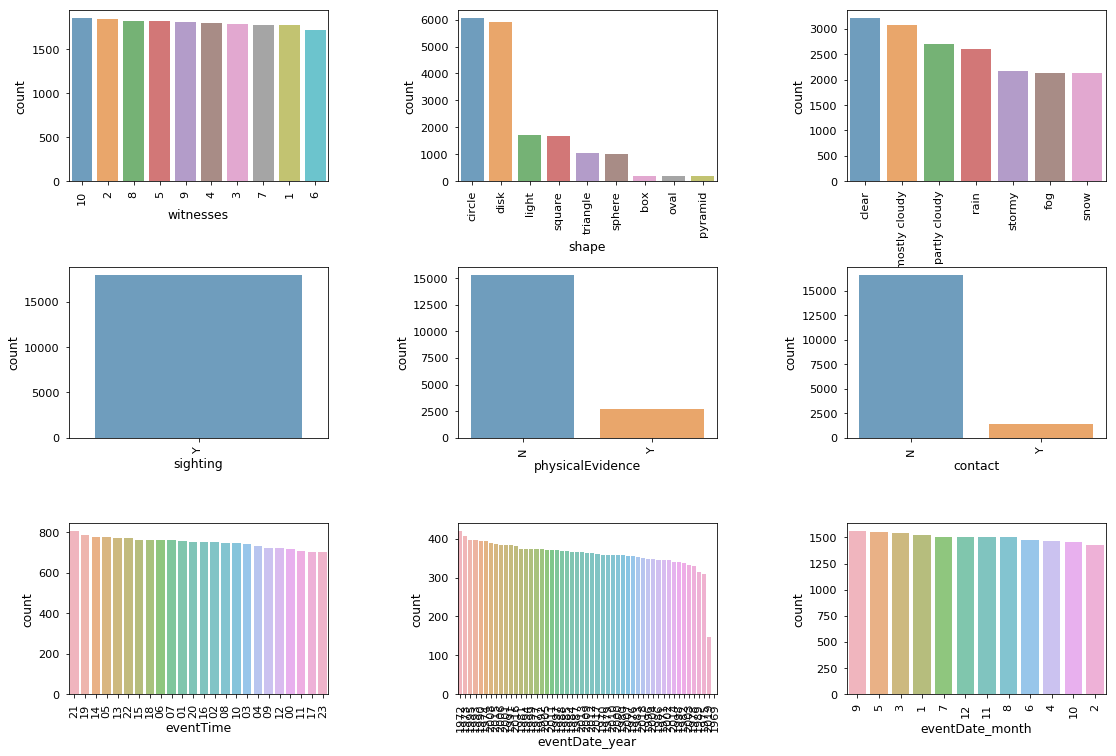

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

cat_feature_list=['witnesses','shape','weather','sighting','physicalEvidence','contact','eventTime','eventDate_year','eventDate_month']
fig, axes=plt.subplots(round(len(data[cat_feature_list].columns)/3),3, figsize=(16, 5))
for i, ax in enumerate(fig.axes):
    if i<len(data[cat_feature_list].columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
        sns.countplot(x=data[cat_feature_list].columns[i], alpha=0.7, data=data[cat_feature_list], ax=ax,
                      order=data[data[cat_feature_list].columns[i]].value_counts().index)
plt.subplots_adjust(left=0.1, bottom=0.1, right=1, top=2, wspace=0.5, hspace=0.5)
plt.show()

#### Relationships between features & target

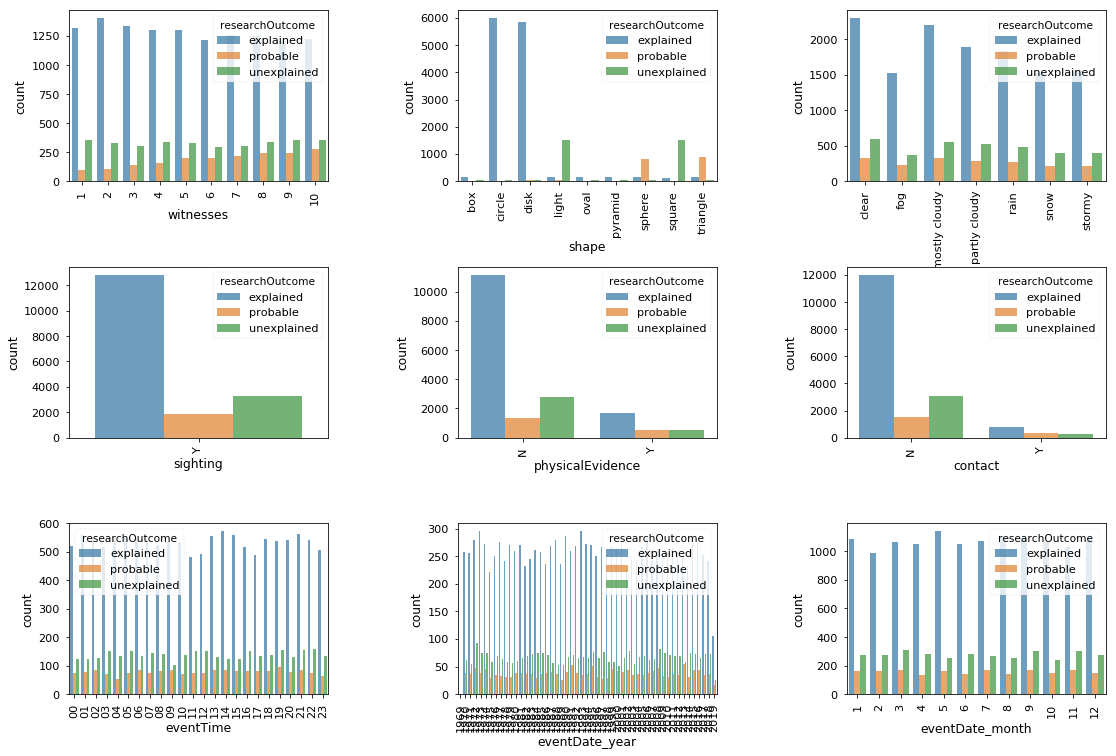

In [13]:
cat_feature_with_target_list=['witnesses','shape','weather','sighting','physicalEvidence','contact','eventTime','eventDate_year','eventDate_month','researchOutcome']
fig, axes=plt.subplots(round(len(data[cat_feature_with_target_list].columns)/3), 3, figsize=(16, 5))
for i, ax in enumerate(fig.axes):
    if i<len(data[cat_feature_with_target_list].columns)-1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
        sns.countplot(x=data[cat_feature_with_target_list].columns[i],hue="researchOutcome",alpha=0.7, data=data[cat_feature_with_target_list], ax=ax)
plt.subplots_adjust(left=0.1, bottom=0.1, right=1, top=2, wspace=0.5, hspace=0.5)
plt.show()

#### Summary
<ul>
    <li>the 'sighting' feature by definition is always 'Y' therefor not relevant, can be removed</li>
    <li>'witnesses','weather','eventTime','eventDate_year', and 'eventDate_month' - from the histograms it can be seen that they very close to uniformly distributed, same behaviour can be seen with the relationship with the target plot, therefore we can remove them. </li>
</ul>

### EDA for Numerical Features<a id='eda-n'></a>
#### Histograms

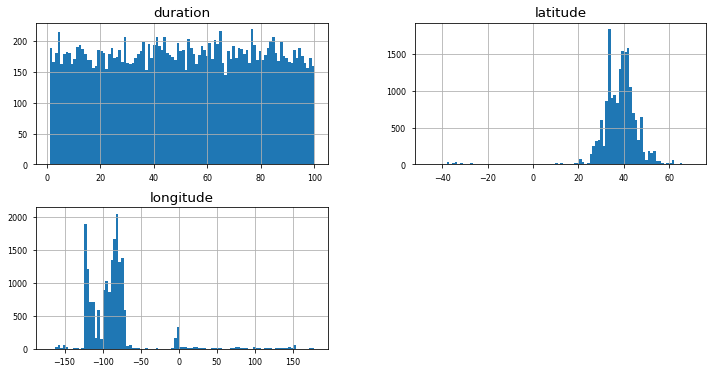

In [14]:
num_feature_list=['duration','latitude','longitude']
data[num_feature_list].hist(figsize=(12,6),bins=100,xlabelsize=8,ylabelsize=8)
plt.show(block = False)

#### Relationships between features & target

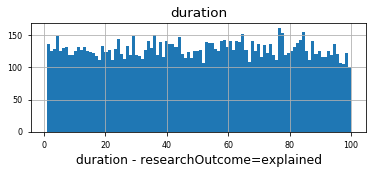

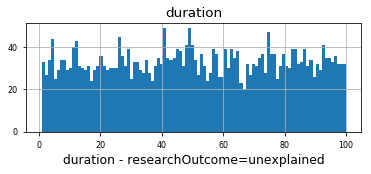

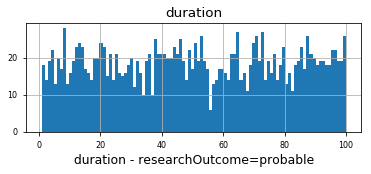

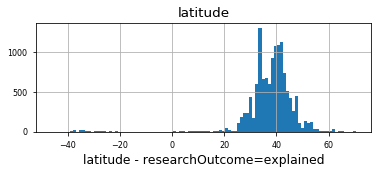

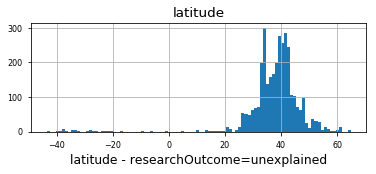

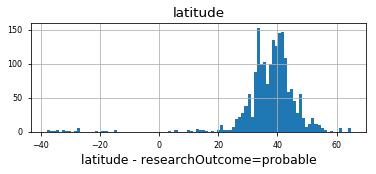

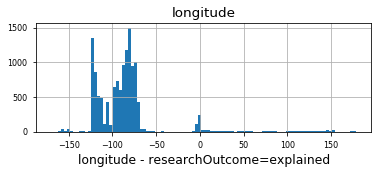

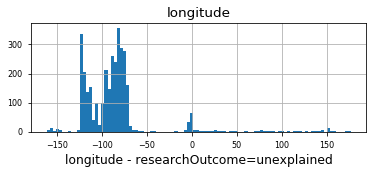

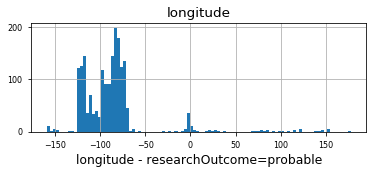

In [15]:
researchOutcome_list=['explained','unexplained','probable']
num_feature_list=['duration','latitude','longitude']
for num_feature in num_feature_list:
    sub_data=data[[num_feature,'researchOutcome']]
    for researchOutcome_val in researchOutcome_list:
        filtered_sub_data=sub_data['researchOutcome']==researchOutcome_val
        sub_data[filtered_sub_data].hist(figsize=(6,2),bins=100,xlabelsize=8,ylabelsize=8,column=num_feature)
        plt.xlabel(num_feature+' - researchOutcome='+researchOutcome_val)
        plt.show(block = False)

## Feature Selection<a id='fs'></a>

by using intuitive feature selection with the summary from the EDA part, we will drop the next columns:
1. 'sighting' - by definition is always 'Y' therefor not relevant.
2. 'reportedTimestamp' - it is a duplicated data, we have the 'eventDate' and 'eventTime', <b>already dropped</b>
3. 'firstName' - it is reasonable to assume that this field will not be useful to predict the target
4. 'lastName' - it is reasonable to assume that this field will not be useful to predict the target.
5. 'witnesses' -  from the relationship with the target plot it can be seen that the target value is not effect the distribution.
6. 'weather' - from the relationship with the target plot it can be seen that the target value is not effect the distribution.
7. 'eventTime' - from the relationship with the target plot it can be seen that the target value is not effect the distribution.
8. 'eventDate_year' - from the relationship with the target plot it can be seen that the target value is not effect the distribution.
9. 'eventDate_month' - from the relationship with the target plot it can be seen that the target value is not effect the distribution.

In [16]:
drop_columns=['sighting','firstName','lastName','witnesses','weather','eventTime','eventDate_year','eventDate_month']
data.drop(drop_columns, axis=1, inplace=True)

In [17]:
data.head()

,shape,duration,latitude,longitude,physicalEvidence,contact,researchOutcome
0,circle,4,47.329444,-122.578889,N,N,explained
1,disk,4,52.664913,-1.034894,Y,N,explained
2,circle,49,38.951667,-92.333889,N,N,explained
3,disk,13,41.496944,-71.367778,N,N,explained
4,circle,17,47.606389,-122.330833,N,N,explained


## Data Preparation<a id='dp'></a>
### Data Encoding

In [18]:
# encode 'physicalEvidence' feature to a new column - 'hasPhysicalEvidence'
data['hasPhysicalEvidence'] = data['physicalEvidence'].replace({'Y': 1, 'N': 0})
data.drop(columns=['physicalEvidence'], inplace=True)

# encode 'contact' feature to a new column - 'hadContact'
data['hadContact'] = data['contact'].replace({'Y': 1, 'N': 0})
data.drop(columns=['contact'], inplace=True)

# encode target column to numbers
data['researchOutcome'] = data['researchOutcome'].replace({'unexplained': 0, 'explained': 1, 'probable': 2})

# one-hot encoding for 'shape' feature
data=pd.get_dummies(data,columns=['shape'])

# see the data
display(data.head())
display(data.shape)

,duration,latitude,longitude,researchOutcome,hasPhysicalEvidence,hadContact,shape_box,shape_circle,shape_disk,shape_light,shape_oval,shape_pyramid,shape_sphere,shape_square,shape_triangle
0,4,47.329444,-122.578889,1,0,0,0,1,0,0,0,0,0,0,0
1,4,52.664913,-1.034894,1,1,0,0,0,1,0,0,0,0,0,0
2,49,38.951667,-92.333889,1,0,0,0,1,0,0,0,0,0,0,0
3,13,41.496944,-71.367778,1,0,0,0,0,1,0,0,0,0,0,0
4,17,47.606389,-122.330833,1,0,0,0,1,0,0,0,0,0,0,0


(17998, 15)

### Randomize and Split the Data

In [19]:
# Shuffle the Data
from sklearn.utils import shuffle
data_shuffled = shuffle(data)

# we want to use CSV file to feed the model. by AWS, the first column is assumed to be the label
# move 'researchOutcome' to first column
target_col='researchOutcome'
data_shuffled=data_shuffled[[target_col]+[col for col in data_shuffled.columns if col not in [target_col]]]

# split data to train ,validation and ,test
import numpy as np

rand_split = np.random.rand(len(data_shuffled))
train_list = rand_split < 0.6                       # 60% for training
val_list = (rand_split >= 0.6) & (rand_split < 0.8) # 20% for validation
test_list = rand_split >= 0.8                       # 20% for testing

# This dataset will be used to train the model.
data_train = data_shuffled[train_list]

# This dataset will be used to validate the model.
data_val = data_shuffled[val_list]

# This dataset will be used to test the model.
data_test = data_shuffled[test_list]

# This dataset will be used to test the model without the label.
data_test_without_label = data_shuffled[test_list]
data_test_without_label = data_test_without_label.loc[:, data_test_without_label.columns != 'researchOutcome']

### Create CSV files and Upload to S3

In [20]:
# creating CSV files
file_names_list=['ufo-algorithms-lab-train.csv','ufo-algorithms-lab-validation.csv','ufo-algorithms-lab-test.csv','ufo-algorithms-lab-test-no-label.csv']
data_train.to_csv(file_names_list[0], index=False, header=False)
data_val.to_csv(file_names_list[1], index=False, header=False)
data_test.to_csv(file_names_list[2], index=False, header=False)
data_test_without_label.to_csv(file_names_list[3], index=False, header=False)

In [21]:
# Next we can take the files we just stored onto our Notebook instance and upload them to S3.
import boto3

bucket_name = '<PUT_HERE_THE_BUCKET_NAME>'
folder_path = 'AlgorithmsLab - 2019/'

for file_name in file_names_list:
    boto3.Session().resource('s3').Bucket(bucket_name).Object(folder_path+file_name).upload_file(file_name)

## Train Models<a id='tm'></a>
it was decided to use "Linear Learner" and "XGBoost". so let's do it!

### Models inputs

In [22]:
import sagemaker

# create inputs that our training function can use as a pointer to the files in S3 
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/'.format(bucket_name)+folder_path+file_names_list[0], content_type='text/csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/'.format(bucket_name)+folder_path+file_names_list[1], content_type='text/csv')
s3_input_test = sagemaker.s3_input(s3_data='s3://{}/'.format(bucket_name)+folder_path+file_names_list[2], content_type='text/csv')

### Linear Learner Model<a id='llm'></a>
#### Create a training job

In [23]:
# Here is where the model artifact will be stored
output_location = 's3://{}/{}'.format(bucket_name,folder_path+'linearLearner-output/')

# get IAM role
from sagemaker import get_execution_role
role = get_execution_role()

# Configure training job, establish SagMaker session
sess = sagemaker.Session()

# get ECR container
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner','1')

# create Estimator
LinearLearner_conf = sagemaker.estimator.Estimator(container,
                                                   role,
                                                   train_instance_count=1,
                                                   train_instance_type='ml.m5.4xlarge',
                                                   output_path=output_location,
                                                   sagemaker_session=sess)

#for 'train_instance_type' go to https://aws.amazon.com/sagemaker/pricing/instance-types/

#### Train the Model

In [24]:
from datetime import datetime

training_job_name='ufo-algorithms-linearLearner-classification-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))

# for 'hyperparameters' go to: https://docs.aws.amazon.com/sagemaker/latest/dg/ll_hyperparameters.html
LinearLearner_conf.set_hyperparameters(feature_dim=14,
                                       predictor_type='multiclass_classifier',
                                       num_classes=3,
                                       balance_multiclass_weights='true',
                                       loss='softmax_loss',
                                       normalize_data='false',
                                       optimizer='adam')

data_channels = {
    'train': s3_input_train,
    'validation': s3_input_validation,
    'test':s3_input_test
}

LinearLearner_conf.fit(inputs=data_channels, job_name=training_job_name) 

2019-11-26 12:30:15 Starting - Starting the training job...
2019-11-26 12:30:16 Starting - Launching requested ML instances......
2019-11-26 12:31:17 Starting - Preparing the instances for training...
2019-11-26 12:32:07 Downloading - Downloading input data...
2019-11-26 12:32:35 Training - Downloading the training image.Docker entrypoint called with argument(s): train
[11/26/2019 12:32:52 INFO 140613342459712] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'aut

#metrics {"Metrics": {"validation_weighted_softmax_loss_objective": {"count": 1, "max": 0.342899168717347, "sum": 0.342899168717347, "min": 0.342899168717347}}, "EndTime": 1574771573.388588, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1574771573.388536}

#metrics {"Metrics": {"validation_weighted_softmax_loss_objective": {"count": 1, "max": 0.2928111030916311, "sum": 0.2928111030916311, "min": 0.2928111030916311}}, "EndTime": 1574771573.388658, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1574771573.388647}

#metrics {"Metrics": {"validation_weighted_softmax_loss_objective": {"count": 1, "max": 0.24608574419045803, "sum": 0.24608574419045803, "min": 0.24608574419045803}}, "EndTime": 1574771573.388695, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime


2019-11-26 12:33:06 Uploading - Uploading generated training model
2019-11-26 12:33:06 Completed - Training job completed
Training seconds: 59
Billable seconds: 59


although we provided to the model the test dataset and we can see the "accuracy" in the logs, let's run the test dataset using AWS SageMaker Batch Transform and then built confusion matrix and calculate the "accuracy" by ourselves

#### Batch Transform (test the model)

In [26]:
# https://sagemaker.readthedocs.io/en/stable/transformer.html

LinearLearner_tran=LinearLearner_conf.transformer(instance_count=1,
                                                  instance_type='ml.m5.4xlarge')

bucket_name = '<PUT_HERE_THE_BUCKET_NAME>'
folder_path = 'AlgorithmsLab - 2019/'
data_test_without_label_s3_path='s3://{}/'.format(bucket_name)+folder_path+file_names_list[3]

LinearLearner_tran.transform(data=data_test_without_label_s3_path,
                             content_type='text/csv',
                             split_type='Line',
                             job_name=training_job_name+'-BT',
                             logs=True,
                             wait=True)

Using already existing model: ufo-algorithms-linearLearner-classification-20191126123015


...................Docker entrypoint called with argument(s): serve
Docker entrypoint called with argument(s): serve
[11/26/2019 12:38:28 INFO 140256763815744] loaded entry point class algorithm.serve.server_config:config_api
[11/26/2019 12:38:28 INFO 140256763815744] loading entry points
[11/26/2019 12:38:28 INFO 140256763815744] loaded request iterator text/csv
[11/26/2019 12:38:28 INFO 140256763815744] loaded request iterator application/x-recordio-protobuf
[11/26/2019 12:38:28 INFO 140256763815744] loaded request iterator application/json
[11/26/2019 12:38:28 INFO 140256763815744] loaded request iterator application/jsonlines
[11/26/2019 12:38:28 INFO 140256763815744] loaded response encoder text/csv
[11/26/2019 12:38:28 INFO 140256763815744] loaded response encoder application/x-recordio-protobuf
[11/26/2019 12:38:28 INFO 140256763815744] loaded response encoder application/json
[11/26/2019 12:38:28 INFO 140256763815744] loaded response encoder application/jsonlines
[11/26/2019 12

getting the results from S3:

In [27]:
import json
import io
from urllib.parse import urlparse

def get_csv_output_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:]
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket_name, '{}/{}'.format(prefix, file_name))
    return obj.get()["Body"].read().decode('utf-8')

output = get_csv_output_from_s3(LinearLearner_tran.output_path, '{}.out'.format(file_names_list[3]))
output_df = pd.read_csv(io.StringIO(output), sep=",", header=None)

#save only the prediction results without the score + change to type 'int'
output_df=pd.to_numeric(output_df[0].str.replace('{"predicted_label":','')).astype(int)

#rename the name of the given series object
output_df=output_df.rename("predict_group")

output_df.head()

0    0
1    1
2    0
3    1
4    1
Name: predict_group, dtype: int64

now that we have the predictions using the model we trained, we can built the 'confusion_matrix'.<br>
but first we will need to reset the index for the origin dataset so it will fit the index order of the output from the "Batch Transform job"

In [28]:
y_Actual_temp=data_test['researchOutcome'].reset_index()
y_Actual_temp=y_Actual_temp['researchOutcome']

y_Actual_temp.head()

0    0
1    1
2    1
3    1
4    1
Name: researchOutcome, dtype: int64

#### confusion matrix

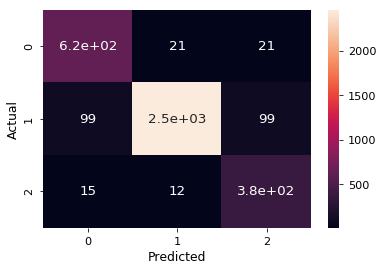

In [29]:
import pandas as pd
import seaborn as sns

data_y = {'y_Predicted': output_df,'y_Actual': y_Actual_temp}
df = pd.DataFrame(data_y, columns=['y_Actual','y_Predicted'])

confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

Getting additional stats using pandas_ml:

In [30]:
!pip install pandas_ml

    100% |████████████████████████████████| 102kB 20.3MB/s a 0:00:01
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [31]:
from pandas_ml import ConfusionMatrix

Confusion_Matrix = ConfusionMatrix(df['y_Actual'], df['y_Predicted'])
Confusion_Matrix.print_stats()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas_ml/confusion_matrix/stats.py:60: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  num = df[df > 1].dropna(axis=[0, 1], thresh=1).applymap(lambda n: choose(n, 2)).sum().sum() - np.float64(nis2 * njs2) / n2


Confusion Matrix:

Predicted    0     1    2  __all__
Actual                            
0          625    21   21      667
1           99  2459   99     2657
2           15    12  377      404
__all__    739  2492  497     3728


Overall Statistics:

Accuracy: 0.9283798283261803
95% CI: (0.919627653616103, 0.9364529334211639)
No Information Rate: ToDo
P-Value [Acc > NIR]: 2.77615e-318
Kappa: 0.8487968854506255
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1           2
Population                                  3728       3728        3728
P: Condition positive                        667       2657         404
N: Condition negative                       3061       1071        3324
Test outcome positive                        739       2492         497
Test outcome negative                       2989       1236        3231
TP: True Positive                            625       2459         377
TN: True Negative              

<font color="green">we can see in the stats report that the "Accuracy" value is: 92.84%, good job!</font>

### XGBoost Model<a id='xgbm'></a>
#### Create a training job

In [32]:
bucket_name = 'allcloud-idan-aws-certified-ml-2019'
folder_path = 'AlgorithmsLab - 2019/'

# Here is where the model artifact will be stored
output_location = 's3://{}/{}'.format(bucket_name,folder_path+'XGBoost-output/')

# get IAM role
from sagemaker import get_execution_role
role = get_execution_role()

# Configure training job, establish SagMaker session
sess = sagemaker.Session()

# get ECR container
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

# create Estimator
XGBoost_conf = sagemaker.estimator.Estimator(container,
                                             role,
                                             train_instance_count=1,
                                             train_instance_type='ml.m5.4xlarge',
                                             output_path=output_location,
                                             sagemaker_session=sess)

#for 'train_instance_type' go to https://aws.amazon.com/sagemaker/pricing/instance-types/

	get_image_uri(region, 'xgboost', '0.90-1').


#### Train the Model

In [ ]:
from datetime import datetime

training_job_name='ufo-algorithms-XGBoost-classification-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))

# for 'hyperparameters' go to: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html
XGBoost_conf.set_hyperparameters(num_round=10,
                                 num_class=3,
                                 max_depth=5,
                                 silent=0,
                                 objective='multi:softmax')

data_channels = {
    'train': s3_input_train,
    'validation': s3_input_validation
}

XGBoost_conf.fit(inputs=data_channels,job_name=training_job_name,logs=True) 

2019-11-26 12:46:24 Starting - Starting the training job...
2019-11-26 12:46:25 Starting - Launching requested ML instances...
2019-11-26 12:47:23 Starting - Preparing the instances for training......
2019-11-26 12:48:12 Downloading - Downloading input data...
2019-11-26 12:48:51 Training - Training image download completed. Training in progress..Arguments: train
[2019-11-26:12:48:51:INFO] Running standalone xgboost training.
[2019-11-26:12:48:51:INFO] File size need to be processed in the node: 0.73mb. Available memory size in the node: 54877.0mb
[2019-11-26:12:48:51:INFO] Determined delimiter of CSV input is ','
[12:48:51] S3DistributionType set as FullyReplicated
[12:48:51] 10723x14 matrix with 150122 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-11-26:12:48:51:INFO] Determined delimiter of CSV input is ','
[12:48:51] S3DistributionType set as FullyReplicated
[12:48:52] 3547x14 matrix with 49658 entries loaded from /opt/ml/input/data/valida

although we provided to the model the test dataset and we can see the "accuracy" in the logs, let's run the test dataset using AWS SageMaker Batch Transform and then built confusion matrix and calculate the "accuracy" by ourselves

#### Batch Transform (test the model)

In [34]:
# https://sagemaker.readthedocs.io/en/stable/transformer.html

XGBoost_tran=XGBoost_conf.transformer(instance_count=1,
                                      instance_type='ml.m5.4xlarge')

bucket_name = '<PUT_HERE_THE_BUCKET_NAME>'
folder_path = 'AlgorithmsLab - 2019/'
data_test_without_label_s3_path='s3://{}/'.format(bucket_name)+folder_path+file_names_list[3]

XGBoost_tran.transform(data=data_test_without_label_s3_path,
                       content_type='text/csv',
                       split_type='Line',
                       job_name=training_job_name+'-BT',
                       logs=True,
                       wait=True)

..................
Arguments: serve
[2019-11-26 12:52:53 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2019-11-26 12:52:53 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2019-11-26 12:52:53 +0000] [1] [INFO] Using worker: gevent
[2019-11-26 12:52:53 +0000] [44] [INFO] Booting worker with pid: 44
[2019-11-26 12:52:53 +0000] [45] [INFO] Booting worker with pid: 45
[2019-11-26:12:52:53:INFO] Model loaded successfully for worker : 44
[2019-11-26:12:52:53:INFO] Model loaded successfully for worker : 45
[2019-11-26 12:52:53 +0000] [46] [INFO] Booting worker with pid: 46
Arguments: serve
[2019-11-26 12:52:53 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2019-11-26 12:52:53 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2019-11-26 12:52:53 +0000] [1] [INFO] Using worker: gevent
[2019-11-26 12:52:53 +0000] [44] [INFO] Booting worker with pid: 44
[2019-11-26 12:52:53 +0000] [45] [INFO] Booting worker with pid: 45
[2019-11-26:12:52:53:INFO] Model loaded successfully for worker : 4

getting the results from S3:

In [35]:
import json
import io
from urllib.parse import urlparse
import pandas as pd

def get_csv_output_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:]
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket_name, '{}/{}'.format(prefix, file_name))
    return obj.get()["Body"].read().decode('utf-8')

output = get_csv_output_from_s3(XGBoost_tran.output_path, '{}.out'.format(file_names_list[3]))
output_df = pd.read_csv(io.StringIO(output), sep=",", header=None)

#change to type 'int'
output_df=output_df.astype(int)

#rename the name of the given DataFrame object
output_df=output_df.rename(columns={0: "predict_group"})

output_df.head()

,predict_group
0,0
1,1
2,0
3,1
4,1


now that we have the prediction using the model we trained, we can built the 'confusion_matrix'. but first we will need to reset the index for the origin dataset so it will fit the index order of the output from the "Batch Transform job"

In [36]:
y_Actual_temp=data_test['researchOutcome'].reset_index()
y_Actual_temp=y_Actual_temp['researchOutcome']

y_Actual_temp.head()

0    0
1    1
2    1
3    1
4    1
Name: researchOutcome, dtype: int64

#### confusion matrix

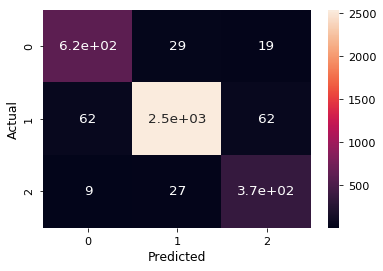

In [37]:
import pandas as pd
import seaborn as sns

data_y = {'y_Predicted': output_df["predict_group"],'y_Actual': y_Actual_temp}
df = pd.DataFrame(data_y, columns=['y_Actual','y_Predicted'])

confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

Getting additional stats using pandas_ml

In [ ]:
!pip install pandas_ml

In [38]:
from pandas_ml import ConfusionMatrix

Confusion_Matrix = ConfusionMatrix(df['y_Actual'], df['y_Predicted'])
Confusion_Matrix.print_stats()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas_ml/confusion_matrix/stats.py:60: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  num = df[df > 1].dropna(axis=[0, 1], thresh=1).applymap(lambda n: choose(n, 2)).sum().sum() - np.float64(nis2 * njs2) / n2


Confusion Matrix:

Predicted    0     1    2  __all__
Actual                            
0          619    29   19      667
1           62  2533   62     2657
2            9    27  368      404
__all__    690  2589  449     3728


Overall Statistics:

Accuracy: 0.944206008583691
95% CI: (0.9363488207107747, 0.951357247195086)
No Information Rate: ToDo
P-Value [Acc > NIR]: 3.244455e-318
Kappa: 0.8784103515782722
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                        0          1          2
Population                                  3728       3728       3728
P: Condition positive                        667       2657        404
N: Condition negative                       3061       1071       3324
Test outcome positive                        690       2589        449
Test outcome negative                       3038       1139       3279
TP: True Positive                            619       2533        368
TN: True Negative                     

<font color="green">we can see in the stats report that the "Accuracy" value is: 94.42%, good job!</font>

## Results<a id='res'></a>

Linear Learner Model - Accuracy=92.84%<br>
XGBoost Model - Accuracy=94.42%

from the results, we can see that we get a pretty good accuracy value from both of the models, but XGBoost has a higher accuracy value.<br>
for future use for a multi-classification problem I will surly choose XGBoost over Linear Learner.